# Differential Privacy for ML Course - Lab #2

*Master IASD, PSL - O. Cappé, January 2025*

This second lab is devoted to the use of the basic DP mechanism seen in the couse.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

## The Dataset

For this lab, we will use the UCI Indian Liver Patient Records Data Set. The dataset consists of liver patient records collected from Andhra Pradesh, India. You can read more about the dataset [here](https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset)). We will begin by loading the data from [OpenML](https://www.openml.org/) using `fetch_openml` method of `sklearn`.

In [2]:
openml = False
if (openml):
    data = fetch_openml(name='Indian-Liver-Patient-Records', version=2, as_frame=True).frame    # Load dataset from OpenML as a Pandas data rrame
else:
    # Backup solution, reading from a local CSV file
    data = pd.read_csv('/content/lab2_indian-liver.csv')
data.head(10)     # Print the first 10 rows of the dataset

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.3,1
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.0,1
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.1,1
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.2,2
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.0,1


## Counting Query

This is a preparatory question in which we will go through the implementation of the Laplace mechanism for a simple counting query. The query should return the number of females in the dataset. You will use the `Gender` attribute in the dataset for this task. The code and plots done for this question will serve as the model for you for answering the rest of the questions.

We will use the variable `count` to store the non-private count of females in the dataset.

In [3]:
count = sum(data['Gender'] == 'Female')
print(count)

142


In the following code block, the function `countLap` implements the Laplace mechanism to return the count of the number of females. **Why is this $\epsilon$-DP?**

This is ϵ-DP because noise drawn from the Laplace distribution is added to the data to mask individual contribution.

In [4]:
def countLap(count, eps):
    """
    Adds Laplace noise to a given count for differential privacy.

    Parameters:
    count (int or float): The original count.
    eps (float): The privacy parameter epsilon.

    Returns:
    float: The count with added Laplace noise.
    """
    return count + np.random.laplace(0, 1/eps)

We can visualize the output of the `countLap` method by running the method several times and plotting the histogram of the returned counts.

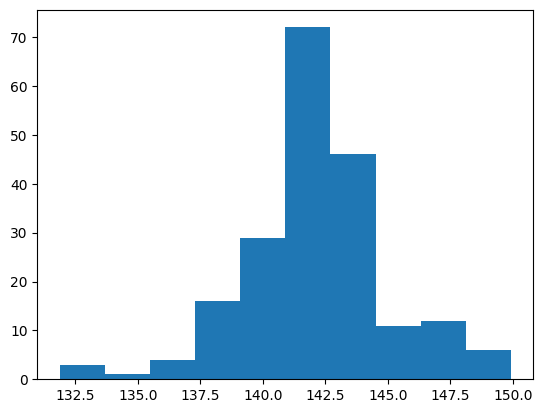

In [5]:
eps = 0.5           # The epsilon value for epsilon-DP
num_iter = 200     # Number of Monte carlo runs of the countLap mechanism
counts = [countLap(count, eps) for i in range(num_iter)]  # Counts is a list of all the noisy counts returned by the countLap mechanism
plt.hist(counts)    # Plot the histogram of counts
plt.show()

In the following code block, we will illustrate more systematically the accuracy of the `countLap` method for a range of $\epsilon$'s.

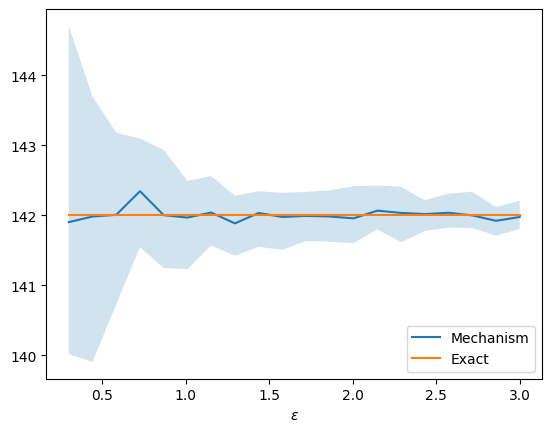

In [6]:
def accuracy_plot(mechanism, data, value):
    """
    Plots the accuracy of a given differential privacy mechanism over a range of epsilon values.
    Parameters:
    mechanism (function): The differential privacy mechanism to be evaluated. It should take two arguments: data and epsilon.
    value (float): The true value that is protected by the mechanism
    """
    num_iter = 100                                  # Number of Monte Carlo runs for each epsilon
    eps_arr = np.linspace(0.3, 3.0, num=20)         # Array of epsilons
    noisy_values_median = np.zeros_like(eps_arr)    # Array of median noisy values returned by the mechanism
    noisy_values_q1 = np.zeros_like(eps_arr)        # Array to store the first quartile of noisy values
    noisy_values_q3 = np.zeros_like(eps_arr)        # Array to store the third quartile of noisy values

    for i, eps in enumerate(eps_arr):
        values = [mechanism(data, eps) for i in range(num_iter)]
        noisy_values_median[i] = np.median(values)
        noisy_values_q1[i] = np.percentile(values, 25)
        noisy_values_q3[i] = np.percentile(values, 75)

    fig = plt.figure()
    plt.plot(eps_arr, noisy_values_median, label='Mechanism')
    plt.plot(eps_arr, value*np.ones_like(eps_arr), label='Exact')
    plt.fill_between(eps_arr, noisy_values_q1, noisy_values_q3, alpha = 0.2)
    plt.legend(loc="lower right")
    plt.xlabel("$\epsilon$")
    plt.show()

accuracy_plot(countLap, count, count)

#### Observations

- Notice that the smaller $\epsilon$ is, the greater is the "spread" or the standard deviation of the noisy counts of `countLap`
- Notice that the mean of the noisy counts returned by `countLap` roughly equals the Exact count. This is because the Laplace noise is mean zero. In other words, the output of `countLap` is an unbiased estimate of `count`.

# L1.1 Differentially Private Maximum

In this question and the following, we will consider the age feature for females. We know from the data documentation that this feature has been truncated at 90.

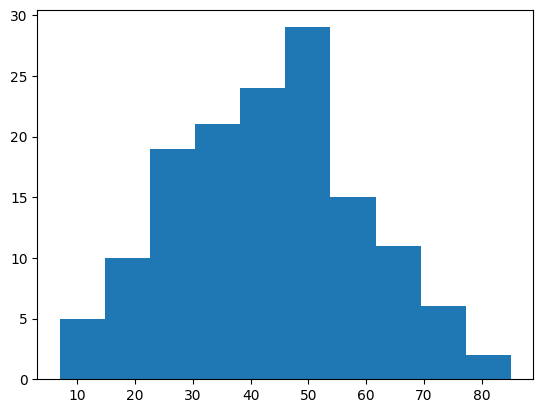

In [7]:
# Return an array with the ages of females
ages = np.array(data[data['Gender'] == 'Female']['Age'])
plt.hist(ages)
plt.show()

**Implement the Laplace mechanism for the maximum as a function and use the <code>accuracy_plot</code> function above to plot its accuracy. What do you think of the result and why is this happening?**

Return maximum edge what will the Laplace mechanism will look like. We want to add laplace noise, what is its value. The max edge has to be less than 90.

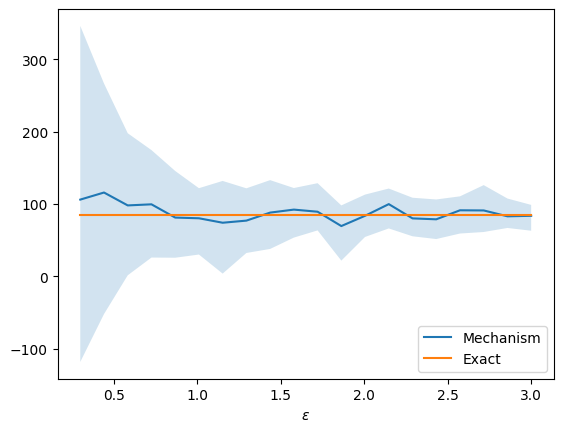

In [ ]:
def maxLap(ages, eps):
    """
    Computes the differentially private maximum of an array of ages using the Laplace mechanism.

    Parameters:
    ages (numpy.ndarray): An array of ages.
    eps (float): The privacy parameter epsilon, which controls the amount of noise added.

    Returns:
    float: The differentially private maximum of the ages array.
    """
    # TODO: Your code here
    #sensitivity of the max fn is 90  p.35 L2, scale 90/eps

    dp_max = np.max(ages) + np.random.laplace(0, 90/(eps))

    return dp_max



accuracy_plot(maxLap, ages, np.max(ages))

This introduces a large amount of noise which leads to a widely inacurate results, so while it protects privacy less accurate than the countLap for example. We can see that the variance is also more important.

Note that we could "improve" the result somewhat by truncating the output value between 0 and 90 for consistency (why is it possible to do so ?). trucate more in this intervale

We can also be less pessimistic about the range of values where we expect to find the maximum. For instance, show that the following mechanism is still $\epsilon$-DP.

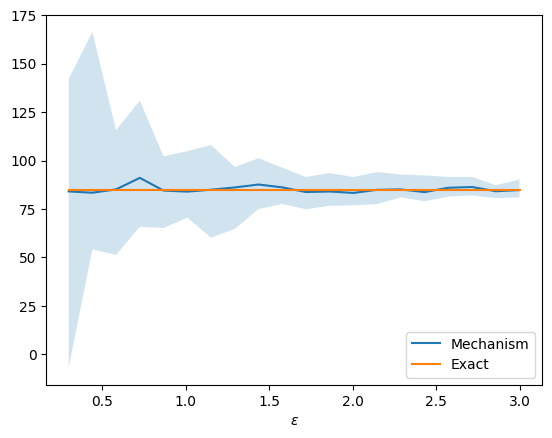

In [ ]:
def maxLap2(ages, eps):
    # Another mechanism to return the differentially private uncensored max age
    guess = 80
    split = 1/4
    n = sum(ages >= guess) + np.random.laplace(0, 1/(split*eps)) # counting query ages >90, split to split the privacy budget for n and dpmax
    if (n > 1):
        dpmax = max(guess, np.max(ages)) + np.random.laplace(0, (90-guess)/((1-split)*eps))#reduced sensitivity
    else:
        dpmax = np.max(ages) + np.random.laplace(0, 90/((1-split)*eps))
    return dpmax

accuracy_plot(maxLap2, ages, np.max(ages))

# 85 max age cant use it because gives information when reading the code output is better because smaller sensitivity, n should be epsilone DP

## L1.2 Differentially Private Arg Max

In this question, we will implement two mechanisms for reporting the id of the maximum of a feature. Specifically, we will implement algorithms that report the id of the most represented age categories among the females.

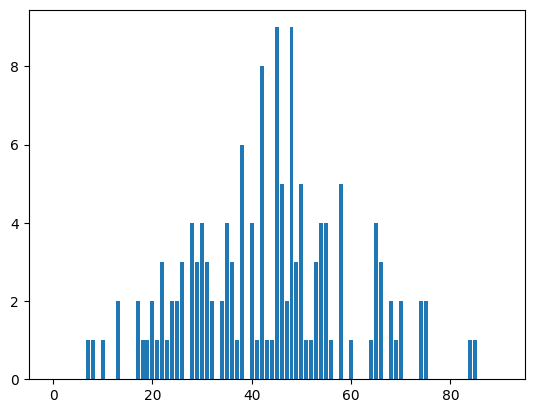

In [8]:
age_counts = np.array([np.sum(ages == i) for i in range(91)])
plt.bar(range(91), age_counts)
plt.show()

### L1.2.1 Noisy Max with Laplace Mechanism

**In the following code block, implement the `reportNoisyArgMax` function that implements the mechanism discussed in class that adds i.i.d. Laplace noise to the entries of the array and reports the index of the maximum in the noisy array.**

In [9]:
# Implement your mechanism here

def reportNoisyArgMax(x, eps):
    """
    Computes the noisy argmax of an array using Laplace noise.
    This function adds Laplace noise to each element of the input array `x`
    and returns the index of the maximum value in the noisy array.
    Parameters:
    x (array-like): The input array for which the noisy argmax is to be computed.
    eps (float): The privacy parameter epsilon.
    Returns:
    int: The index of the maximum value in the noisy array.
    """

    noisy_x = x + np.random.laplace(0, 1/eps, len(x)) # the sensitivity is one because it is a count-base query

    return np.argmax(noisy_x)


We can visualize the accuracy of the output of the `reportNoisyArgMax` method by running the mechanism several times and plotting the histogram of the ages corresponding to the returned indices.

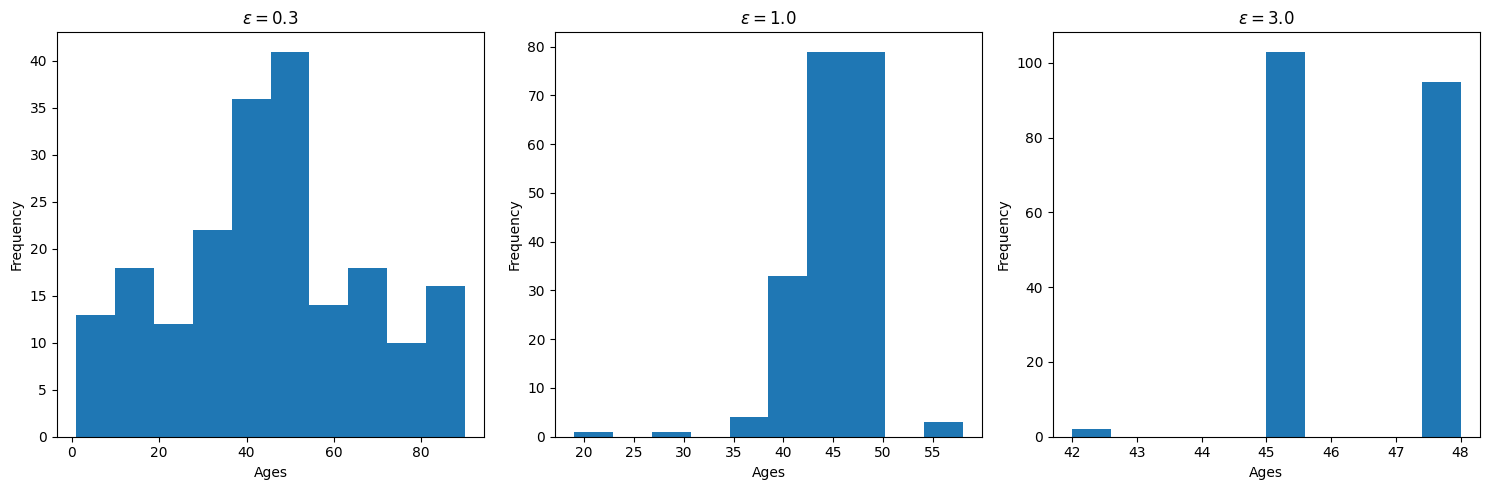

In [10]:
def accuracy_plot_for_argmax(mechanism, age_counts):
    eps_arr = np.array([0.3, 1, 3])
    num_iter = 200

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, eps in enumerate(eps_arr):
        age_ids = [mechanism(age_counts, eps) for _ in range(num_iter)]
        axs[i].hist(age_ids)
        axs[i].set_xlabel('Ages')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title('$\epsilon = {}$'.format(eps))

    plt.tight_layout()
    plt.show()

accuracy_plot_for_argmax(reportNoisyArgMax, age_counts)

As we can see the higher epsilon is the less privacy we have.

### L1.2.2 Noisy Max with the Exponential Mechanism

We now consider addressing the same task using the Exponential mechanism. **What is the natural utility function $u(x,y)$ and what is its sensitivity?**

**Implement the exponential mechanism with the chosen utility function and illustrate the accuracy of the mechanism using the same plots as before.**

In [15]:
def argMaxExp(x,eps):

    # Compute probability distribution
    utility = age_counts
    probabilities = np.exp((eps * utility) / (2))
    probabilities /= np.sum(probabilities)

    # Sample an index based on probabilities
    return np.random.choice(len(utility), p=probabilities)


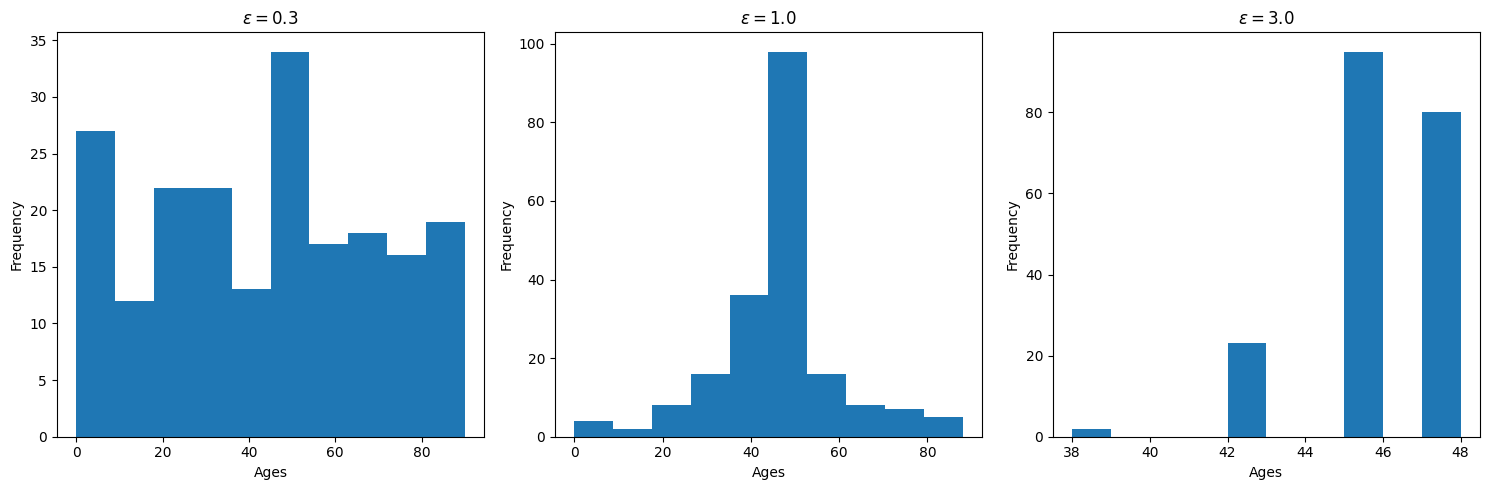

In [16]:
accuracy_plot_for_argmax(argMaxExp, age_counts)